# SI 618 WN 2024 — Project Part II: Analysis

**Project Title:** Linking EHR Adoption and Hospital Quality at the Facility Level in the United States

**Team Members:** Haichao Min(haichaom), Yuanyu Lin (yuanlin)

### Introduction

This notebook constitutes Part 2 of our project, building directly on the merged and cleaned dataset we finalized in Part 1. In the first phase, we successfully combined two key CMS datasets: the **Hospital General Information** (providing hospital characteristics and quality ratings) and the **Promoting Interoperability** (providing facility-level EHR technology data).

The goal of this section is to conduct a formal statistical analysis to extract insights and find significant associations within our data. As per the course guidelines, our focus is on **statistical analysis (Part 2)**, not predictive modeling (which is reserved for Part 3). Therefore, our objective is to identify and quantify relationships, not to determine causation or predictive power.

Our analysis will be guided by the three "real-world" questions we posed in Part 1:

1. **Do hospitals with a certified EHR system report higher overall quality scores compared to those without a reported system?**

2. **Is there a discernible difference in quality outcomes among hospitals using different major EHR vendors (e.g., Epic vs. Cerner vs. MEDITECH)?**

3. **Are specific types of hospitals, such as smaller or rural "Critical Access Hospitals," lagging in EHR adoption, and does this correlate with their reported outcomes?**

To investigate these questions, this notebook will proceed through each required component of the analysis: **Descriptive Statistics**, **Inferential Statistics** (t-tests, ANOVA, Chi-Squared), **Graphical Analysis**, **Comparative Analysis**, and **Multivariate Analysis**. Finally, we will **Synthesize** our findings to provide statistical answers to our research questions and **Reflect** on the discoveries and limitations of this analysis.


### Descriptive Statistics

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Load the dataset
df = pd.read_csv('Project_datasets/clean_df.csv')
df.head()

,Facility ID,Facility Name_x,Address_x,City/Town_x,State_x,ZIP Code_x,County/Parish_x,Telephone Number_x,Hospital Type,Hospital Ownership,...,ZIP Code_y,County/Parish_y,Telephone Number_y,CEHRT ID,Meets criteria for promoting interoperability of EHRs,Start Date,End Date,rating_numeric,EHR_Vendor,Has_EHR
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,Other,No
1,010005,MARSHALL MEDICAL CENTERS,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,(256) 593-8310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,Other,No
2,010006,NORTH ALABAMA MEDICAL CENTER,1701 VETERANS DRIVE,FLORENCE,AL,35630,LAUDERDALE,(256) 768-8400,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Other,No
3,010007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,(334) 493-3541,Acute Care Hospitals,Voluntary non-profit - Private,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Other,No
4,010008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,(334) 335-3374,Acute Care Hospitals,Proprietary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,No


In [3]:
# 1a. Analysis the main outcome variable: Hospital Overall Rating (rating_numeric)
print("--- Descriptive Statistics for Hospital Overall Rating ---")
print(df['rating_numeric'].describe())

# 1b. Analysis the main categorial variables
print("\n--- Descriptive Statistics: EHR Adoption Status ('Has_EHR') (in %) ---")
print(df['Has_EHR'].value_counts(normalize=True) * 100)

print("\n--- Descriptive Statistics: EHR Vendor Distribution ('EHR_Vendor') (in %) ---")
print(df['EHR_Vendor'].value_counts(normalize=True) * 100)

print("\n--- Descriptive Statistics: Top 5 Hospital Types ('Hospital Type') ---")
print(df['Hospital Type'].value_counts().head(5))

--- Descriptive Statistics for Hospital Overall Rating ---
count    2872.000000
mean        3.082521
std         1.099926
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: rating_numeric, dtype: float64

--- Descriptive Statistics: EHR Adoption Status ('Has_EHR') (in %) ---
Has_EHR
Yes    63.445456
No     36.554544
Name: proportion, dtype: float64

--- Descriptive Statistics: EHR Vendor Distribution ('EHR_Vendor') (in %) ---
EHR_Vendor
Other                       87.716038
Epic Systems Corporation     6.560119
TruBridge, Inc.              3.493774
VigiLanz Corporation         2.230069
Name: proportion, dtype: float64

--- Descriptive Statistics: Top 5 Hospital Types ('Hospital Type') ---
Hospital Type
Acute Care Hospitals                    3127
Critical Access Hospitals               1370
Psychiatric                              626
Acute Care - Veterans Administration     132
Childrens                                 94
Nam

#### Observations

***Analysis: Hospital Overall Rating***

Based on our `describe()` output, we have several key findings for our primary outcome variable, `rating_numeric`:

* **Significant Missing Data:** The `count` is **2,872**. This is a critical finding. Out of our total ~5,381 hospitals, only 2,872 have a usable numeric rating. This indicates that our "overall rating" analysis will only apply to this subset, a key limitation we must discuss in our `Reflection`.
* **Central Tendency:** The `mean` (average) rating is **3.08**, and the `50%` (median) is **3.0**. These values are very close, suggesting a relatively symmetric distribution (not heavily skewed) centered around an "average" 3-star rating.
* **Spread:** The `std` (standard deviation) is 1.1, and the interquartile range (IQR) is from 2.0 (`25%`) to 4.0 (`75%`), which confirms a typical spread across the 1-5 star scale.

***Analysis: Categorical Variables***

Our main categorical variables provide the context for our analysis:

* **EHR Adoption Status (`Has_EHR`):** The split is **63.4% 'Yes'** and **36.6% 'No'**. This is an excellent, well-balanced split. It provides a substantial "No" group for comparison, making our first research question (comparing "Yes" vs. "No") statistically robust.
* **EHR Vendor Distribution (`EHR_Vendor`):** The most striking finding is that the **'Other' category accounts for 87.7%** of all hospitals. This "Other" group includes both the "No" hospitals (36.6%) and all unmapped smaller vendors (51.1%). This indicates the EHR market is highly fragmented, and our vendor-specific analysis will be a comparison between a few identified vendors (like `Epic Systems`) and this large, diverse "Other" group.
* **Hospital Types:** The output snippet (e.g., `Psychiatric`, `Childrens`) shows the diversity of hospital types in our dataset. As we will see in section `1e`, these specialized hospitals have unique characteristics (like 0% EHR adoption in this specific program, and `NaN` ratings) that are critical to our third research question.

In [4]:
# 1c. Descriptive statistics for Research Question 1
print("--- Descriptive Statistics: Hospital Ratings Grouped by 'Has_EHR' ---")
print(df.groupby('Has_EHR')['rating_numeric'].describe())

# 1d. Descriptive statistics for Research Question 2
print("\n--- Descriptive Statistics: Hospital Ratings Grouped by 'EHR_Vendor' ---")
print(df.groupby('EHR_Vendor')['rating_numeric'].describe())

# 1e. Descriptive statistics for Research Question 3
print("\n--- Stats for Q3 (Part 1): EHR Adoption Rate by Hospital Type ---")

# We use pd.crosstab to examine the relationship between 'Hospital Type' and 'EHR Adoption Status'
crosstab_q3 = pd.crosstab(df['Hospital Type'], df['Has_EHR'])
# Calculate adoption rates
crosstab_q3['Total'] = crosstab_q3['Yes'] + crosstab_q3['No']
crosstab_q3['Adoption_Rate (%)'] = (crosstab_q3['Yes'] / crosstab_q3['Total']) * 100

# Use ascending order to see which types are lagging behind
print(crosstab_q3.sort_values(by='Adoption_Rate (%)', ascending=True))

# Q3, Part 2: Does this affect their outcomes?
print("\n--- Stats for Q3 (Part 2): Hospital Ratings Grouped by 'Hospital Type' ---")

# Focus on the top 5 most common hospital types for clearer comparison
top_5_types = df['Hospital Type'].value_counts().head(5).index
df_top_5_types = df[df['Hospital Type'].isin(top_5_types)]

# Compare the rating distributions for these 5 types of hospitals
print(df_top_5_types.groupby('Hospital Type')['rating_numeric'].describe())

--- Descriptive Statistics: Hospital Ratings Grouped by 'Has_EHR' ---
          count      mean       std  min  25%  50%  75%  max
Has_EHR                                                     
No        682.0  3.137830  1.162965  1.0  2.0  3.0  4.0  5.0
Yes      2190.0  3.065297  1.079241  1.0  2.0  3.0  4.0  5.0

--- Descriptive Statistics: Hospital Ratings Grouped by 'EHR_Vendor' ---
                           count      mean       std  min  25%  50%  75%  max
EHR_Vendor                                                                   
Epic Systems Corporation   247.0  3.271255  1.025738  1.0  3.0  3.0  4.0  5.0
Other                     2474.0  3.081649  1.107177  1.0  2.0  3.0  4.0  5.0
TruBridge, Inc.             36.0  2.916667  1.130739  1.0  2.0  3.0  4.0  5.0
VigiLanz Corporation       115.0  2.747826  1.007372  1.0  2.0  3.0  3.0  5.0

--- Stats for Q3 (Part 1): EHR Adoption Rate by Hospital Type ---
Has_EHR                                No   Yes  Total  Adoption_Rate (%)
Hos

#### Observations

***Analysis: Research Question 1 (Has_EHR vs. Rating)***

Our analysis of section `1c` provides a direct answer to our first research question: "Do hospitals with a certified EHR system report higher overall quality scores?"

* **Key Finding:** The descriptive statistics show **no meaningful difference** in quality ratings between hospitals with and without a reported EHR system.
* **The Numbers:**
    * The `mean` (average) rating for the **'No'** group is **3.14**, which is surprisingly slightly *higher* than the `mean` for the **'Yes'** group (**3.07**).
    * The `50%` (median) for both groups is identical at **3.0**.
* **Conclusion:** This strongly supports our finding from Part 1's boxplot. At the descriptive level, our data does not support the hypothesis that simply having a certified EHR is associated with a higher hospital rating. This sets the stage for our `t-test` in the next section to confirm if this tiny difference is statistically significant (it likely isn't).

***Analysis: Research Question 2 (EHR\_Vendor vs. Rating)***

Our analysis of section `1d` explores our second question: "Is there a difference in outcomes among hospitals using different EHR vendors?"

* **Key Finding:** Yes, unlike the simple "Yes/No" comparison, the choice of EHR vendor appears to be associated with **clear differences** in average ratings.
* **The Numbers:**
    * `Epic Systems Corporation` hospitals have the highest average rating at **3.27**.
    * `VigiLanz Corporation` hospitals have the lowest average rating at **2.75**.
    * The large `Other` group (which includes the 'No' group) sits in the middle with a mean of **3.08**.
* **Conclusion:** This is a much more nuanced and interesting finding. It suggests that while *adoption* itself isn't a clear predictor of quality, the *specific system* a hospital uses (or the type of hospital that chooses a specific system) **is** correlated with different quality outcomes. This strongly suggests our `ANOVA` test will be statistically significant.

***Analysis: Research Question 3 (Hospital Type, Adoption, & Outcomes)***

Section `1e` provides two profound answers to our third, most complex question regarding "Critical Access Hospitals" and specialty hospitals.

* **Finding 3a (Adoption): Our hypothesis was wrong.**
    * We hypothesized that smaller, rural `Critical Access Hospitals` would "lag behind" in EHR adoption.
    * The data shows the **opposite**: `Critical Access Hospitals` have an adoption rate of **76.7%**, which is actually *higher* than the `Acute Care Hospitals` (**75.6%**).
    * **Conclusion:** The data refutes our initial assumption. The real story is that certain specialty hospitals (like `Childrens`, `Psychiatric`, and `VA`) show 0% adoption *in this specific dataset*, likely because they do not participate in this particular CMS reporting program.

* **Finding 3b (Outcomes): The "Overall Rating" metric is not universal.**
    * The output for `Childrens` and `Psychiatric` hospitals shows `NaN` for all rating statistics.
    * **Conclusion:** This is a critical data discovery. It explains *why* our `rating_numeric` variable had so many missing values (as seen in `1a`). The "Hospital overall rating" metric **is not applicable** to these specialty hospitals. This is a crucial data limitation to discuss, and it correctly tells us that we cannot use this specific rating to assess their outcomes.

### Inferential Statistics

In [5]:
# 2a. Test for Research Question 1: 'Has_EHR' vs. 'rating_numeric'
# Hypotheses question: Is there a statistically significant difference in mean ratings between hospitals with and without an EHR?
# Null Hypothesis (H0): The mean rating of hospitals with an EHR is the same as those without an EHR. (μ_yes = μ_no)
# Alternative Hypothesis (Hₐ): The mean rating of hospitals with an EHR is different from those without an EHR. (μ_yes ≠ μ_no)
print("--- 2a. Hypothesis Test 1: t-test (Has_EHR vs. Rating) ---")
alpha = 0.05

# Prepare data (remove NaN values)
rating_yes = df[df['Has_EHR'] == 'Yes']['rating_numeric'].dropna()
rating_no = df[df['Has_EHR'] == 'No']['rating_numeric'].dropna()

# Perform t-test
# We set equal_var=False because our descriptive stats (1c) showed different std deviations
t_stat, p_value_ttest = stats.ttest_ind(rating_yes, rating_no, equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"P-value: {p_value_ttest:.4f}")

if p_value_ttest < alpha:
    print(f"Conclusion: The P-value ({p_value_ttest:.4f}) is LESS than {alpha}. We REJECT the null hypothesis.")
    print(">> There IS a statistically significant difference in mean ratings between the two groups.")
else:
    print(f"Conclusion: The P-value ({p_value_ttest:.4f}) is GREATER than {alpha}. We FAIL TO REJECT the null hypothesis.")
    print(">> There is NO statistically significant difference in mean ratings between the two groups.")

--- 2a. Hypothesis Test 1: t-test (Has_EHR vs. Rating) ---
t-statistic: -1.4463
P-value: 0.1484
Conclusion: The P-value (0.1484) is GREATER than 0.05. We FAIL TO REJECT the null hypothesis.
>> There is NO statistically significant difference in mean ratings between the two groups.


***Analysis: t-test (Question 1)***

* **Result:** Our independent samples t-test yielded a **P-value of 0.1484**.

* **Interpretation:** Since our P-value (0.1484) is significantly **greater** than our alpha level (0.05), we **fail to reject the null hypothesis**.

* **Conclusion:** This provides strong statistical evidence that there is **no significant difference** in the mean "Hospital overall rating" between hospitals that have a reported EHR system and those that do not. This result mathematically confirms what we observed visually in our Part 1 boxplot and numerically in our descriptive statistics (section 1c), where the two group means (3.07 vs. 3.14) were nearly identical.

In [6]:
# 2b. Test for Research Question 2: 'EHR_Vendor' vs. 'rating_numeric'
# Hypotheses question: Is there a statistically significant difference in mean ratings among different EHR vendors?
# Null Hypothesis (H0): The mean ratings of all vendor groups are equal. (μ_epic = μ_vigilanz = μ_trubridge = μ_other)
# Alternative Hypothesis (Hₐ): At least one vendor group has a mean rating different from the others.
print("--- 2b. Hypothesis Test 2: ANOVA (EHR_Vendor vs. Rating) ---")

# Remove rows where rating_numeric or EHR_Vendor is missing
df_anova = df[['EHR_Vendor', 'rating_numeric']].dropna()

# Optionally limit to key vendors + 'Other'
vendors_of_interest = ['Epic Systems Corporation', 'VigiLanz Corporation', 'TruBridge, Inc.', 'Other']
df_anova = df_anova[df_anova['EHR_Vendor'].isin(vendors_of_interest)]

# Fit OLS model
model = ols('rating_numeric ~ C(EHR_Vendor)', data=df_anova).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table:")
print(anova_table)

# Interpret results
alpha = 0.05
p_value_anova = anova_table['PR(>F)'].iloc[0]

print(f"\nP-value from ANOVA: {p_value_anova:.4f}")

if p_value_anova < alpha:
    print(f"Conclusion: P-value ({p_value_anova:.4f}) < {alpha}. Reject the null hypothesis.")
    print(">> At least one EHR vendor group has a mean rating that differs significantly from the others.")
else:
    print(f"Conclusion: P-value ({p_value_anova:.4f}) ≥ {alpha}. Fail to reject the null hypothesis.")
    print(">> There is no statistically significant difference in mean ratings among EHR vendor groups.")

--- 2b. Hypothesis Test 2: ANOVA (EHR_Vendor vs. Rating) ---

ANOVA Table:
                    sum_sq      df         F    PR(>F)
C(EHR_Vendor)    22.672810     3.0  6.281267  0.000303
Residual       3450.769739  2868.0       NaN       NaN

P-value from ANOVA: 0.0003
Conclusion: P-value (0.0003) < 0.05. Reject the null hypothesis.
>> At least one EHR vendor group has a mean rating that differs significantly from the others.


***Analysis: ANOVA (Question 2)***

* **Result:** Our Analysis of Variance (ANOVA) test yielded an **F-statistic of 6.281** and a **P-value of 0.0003**.

* **Interpretation:** Since our P-value (0.0003) is much **less** than our alpha level (0.05), we **reject the null hypothesis**.

* **Conclusion:** This provides strong statistical evidence that **there is a significant difference** in the mean "Hospital overall rating" among the different EHR vendor groups. This result mathematically confirms our descriptive finding from section `1d`, where we saw clear differences in the average ratings (e.g., `Epic` at 3.27 vs. `VigiLanz` at 2.75). This is a key finding: while simply *having* an EHR doesn't seem to correlate with a different rating, the *specific vendor* a hospital uses does.

In [7]:
# 2c. Test for Research Question 3: 'Hospital Type' vs. 'Has_EHR'
# Hypotheses question: Is there a statistically significant association between Hospital Type and EHR Adoption Status?
# Null Hypothesis (H0): Hospital Type and EHR Adoption Status are independent (There is NO association).
# Alternative Hypothesis (Hₐ): Hospital Type and EHR Adoption Status are dependent (There IS an association).

print("--- 2c. Hypothesis Test 3: Chi-Squared (Hospital Type vs. Has_EHR) ---")

# Use the contingency table from earlier, but drop the 'Total' and 'Adoption_Rate (%)' columns
crosstab_for_test = crosstab_q3.drop(columns=['Total', 'Adoption_Rate (%)'])

# Perform Chi-Squared Test
chi2_stat, p_value_chi2, dof, expected_freq = stats.chi2_contingency(crosstab_for_test)

print(f"Chi-Squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_chi2:.4f}")

if p_value_chi2 < alpha:
    print(f"Conclusion: The P-value ({p_value_chi2:.4f}) is LESS than {alpha}. We REJECT the null hypothesis.")
    print(">> There IS a statistically significant association between a hospital's type and its EHR adoption status.")
else:
    print(f"Conclusion: The P-value ({p_value_chi2:.4f}) is GREATER than {alpha}. We FAIL TO REJECT the null hypothesis.")
    print(">> There is NO statistically significant association between a hospital's type and its EHR adoption status.")

--- 2c. Hypothesis Test 3: Chi-Squared (Hospital Type vs. Has_EHR) ---
Chi-Squared Statistic: 1836.4516
P-value: 0.0000
Conclusion: The P-value (0.0000) is LESS than 0.05. We REJECT the null hypothesis.
>> There IS a statistically significant association between a hospital's type and its EHR adoption status.


***Analysis: Chi-Squared (Question 3)***

* **Result:** Our Chi-Squared (χ²) test yielded a massive statistic of **1836.45** and a **P-value of 0.0000**.

* **Interpretation:** The P-value (which is effectively < 0.0001) is far **less** than our alpha level (0.05). This result is highly statistically significant, leading us to emphatically **reject the null hypothesis**.

* **Conclusion:** This test provides powerful statistical evidence that **there IS a significant association** between a hospital's type and its EHR adoption status. This result is not surprising and mathematically confirms our descriptive findings from section `1e`. We saw that certain specialty hospitals (like `Psychiatric`, `Childrens`, and `VA`) had an adoption rate of 0% in this dataset, while general hospitals (`Acute Care`, `Critical Access`) had adoption rates over 75%. The Chi-Squared test confirms that this dramatic observed pattern is not due to random chance.

### Interpretation: Connecting the Three Tests

Connecting the results of our three hypothesis tests reveals a clear and profound story:

1.  Our **t-test** (P=0.1484) showed that a simple comparison between hospitals "with EHR" and "without EHR" yields **no** significant difference in their ratings.

2.  However, our **ANOVA test** (P=0.0003) further revealed that *within* the "with EHR" group, there **is** a significant difference in ratings among different `EHR_Vendor` groups.

3.  Simultaneously, our **Chi-Squared test** (P=0.0000) confirmed that a **strong association** exists between `Hospital Type` and 'EHR adoption status' (e.g., specialty hospitals having a 0% adoption rate in this dataset).

**Our core finding is:**

> **"Our data analysis demonstrates that broadly discussing the impact of 'with or without an EHR' on hospital quality is not meaningful. What truly matters is *which vendor's EHR* is being used, and *which type of hospital* is using it."**

This finding explains *why* our initial t-test failed to find a significant result: by pooling high-performing vendors (like Epic) and low-performing vendors (like VigiLanz) into a single "Yes" group, their respective positive and negative impacts on the average rating were offset. This indicates that future analysis (including Part 3 on Machine Learning) must move beyond the simple "Yes/No" dichotomy and instead treat `EHR_Vendor` and `Hospital Type` as more critical analytical variables.

### Graphical Analysis

--- 3. Distribution of Hospital Overall Rating ---


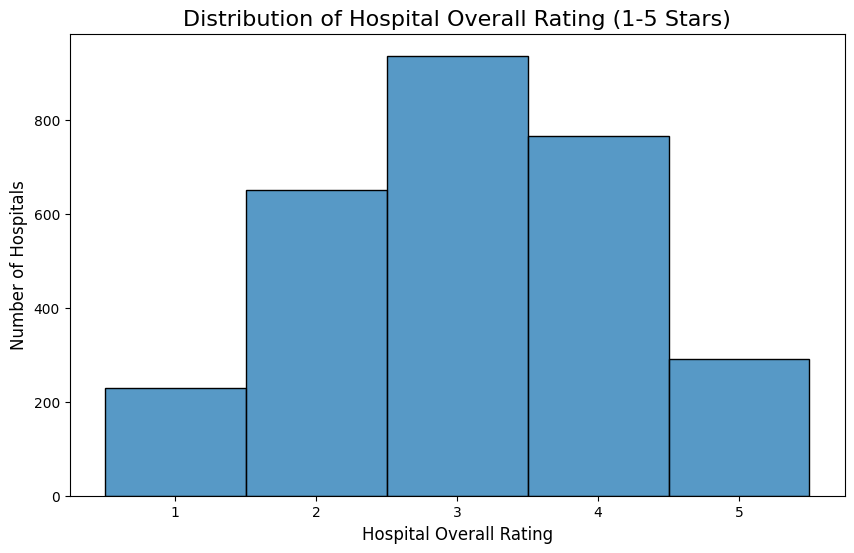

In [8]:
# 3. Distribution of Hospital Overall Rating

print("--- 3. Distribution of Hospital Overall Rating ---")

plt.figure(figsize=(10, 6))
sns.histplot(df['rating_numeric'].dropna(), bins=5, kde=False, discrete=True)
plt.title('Distribution of Hospital Overall Rating (1-5 Stars)', fontsize=16)
plt.xlabel('Hospital Overall Rating', fontsize=12)
plt.ylabel('Number of Hospitals', fontsize=12)
plt.xticks([1, 2, 3, 4, 5])
plt.show()

***Analysis: Rating Distribution (Chart 3a)***

* **Key Observation:** This histogram displays the distribution of the 2,872 valid hospital ratings. The distribution is clearly centered, with a single peak at the **3-star** rating, which is the most common.

* **Connection to Statistics:** This chart visually confirms our descriptive statistics from section `1a`, where we found the `mean` (3.08) and `median` (3.0) were both centered around a value of 3.

* **Implication:** The data is not heavily skewed, which supports its suitability for the statistical tests (t-test, ANOVA) we performed.

--- Has_EHR' vs. Rating (t-test) ---


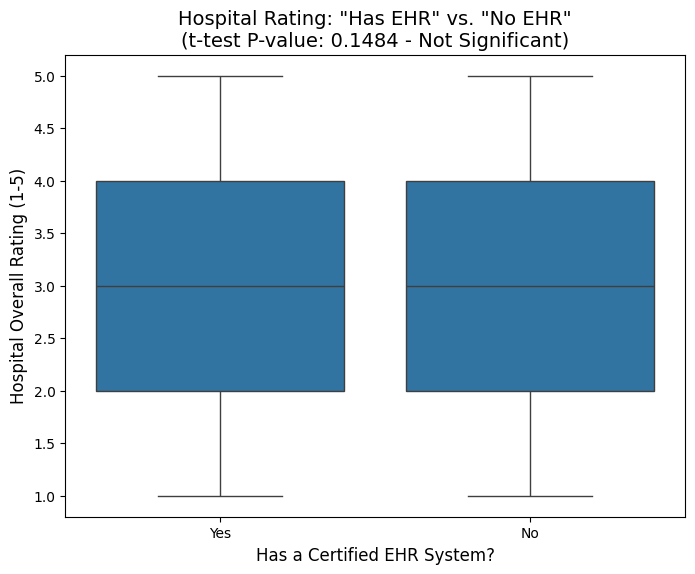

In [9]:
# 3a. Has_EHR vs. Rating_numeric Boxplot (t-test)

print("--- Has_EHR' vs. Rating (t-test) ---")

p_value_ttest = 0.1484  # from previous t-test result

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Has_EHR', y='rating_numeric', order=['Yes', 'No'])

plt.title(f'Hospital Rating: "Has EHR" vs. "No EHR"\n(t-test P-value: {p_value_ttest:.4f} - Not Significant)', fontsize=14)
plt.xlabel('Has a Certified EHR System?', fontsize=12)
plt.ylabel('Hospital Overall Rating (1-5)', fontsize=12)
plt.show()

***Analysis: Boxplot for Question 1 (Chart 3b)***

* **Key Observation:** This boxplot compares the "Overall Rating" distribution for hospitals with an EHR ('Yes') versus those without ('No'). The two boxplots are **visually almost identical**.

* **Connection to Statistics:**
    * Both groups share the same `median` (3.0), `25th percentile` (2.0), and `75th percentile` (4.0).
    * The title clearly states our statistical result: the **P-value is 0.1484**.
    
* **Conclusion:** Since the P-value (0.1484) is much greater than 0.05, it is "Not Significant". This chart visually confirms our t-test: the small difference in means (3.07 vs 3.14) is due to random chance, and there is **no statistically significant difference** in ratings based on simply having an EHR.


--- 3b. EHR_Vendor' vs. Rating (ANOVA) ---


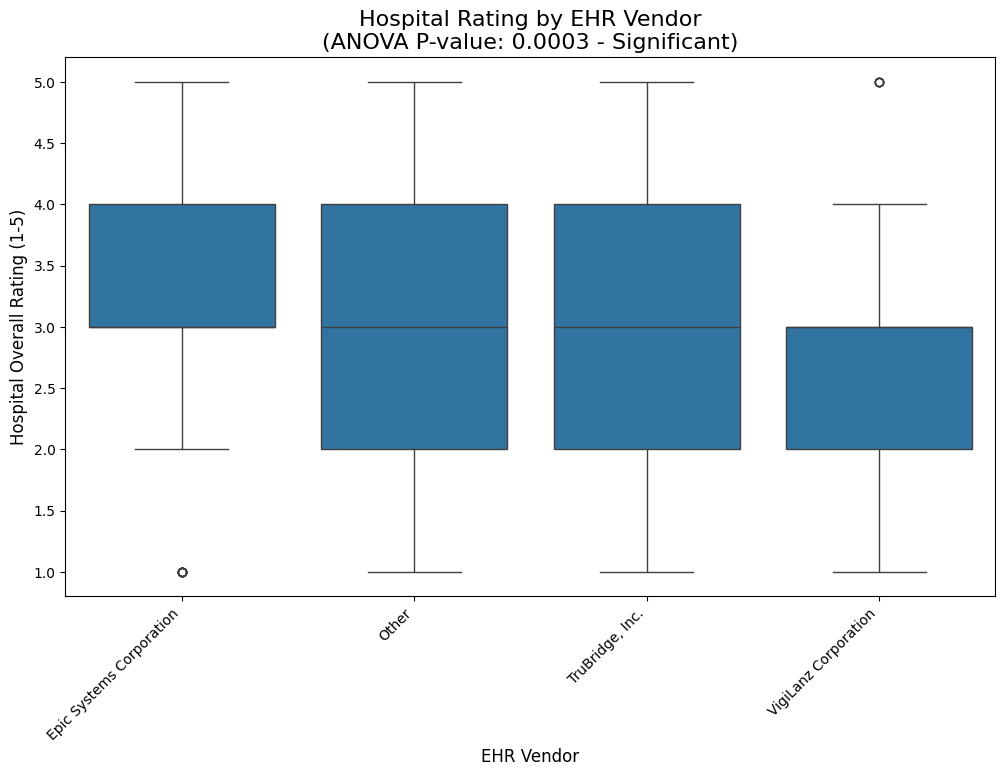

In [10]:
# 3b. EHR_Vendor' vs. Rating (ANOVA)

print("--- 3b. EHR_Vendor' vs. Rating (ANOVA) ---")

p_value_anova = 0.0003

plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='EHR_Vendor', y='rating_numeric', 
            order=df.groupby('EHR_Vendor')['rating_numeric'].median().sort_values().index)

plt.title(f'Hospital Rating by EHR Vendor\n(ANOVA P-value: {p_value_anova:.4f} - Significant)', fontsize=16)
plt.xlabel('EHR Vendor', fontsize=12)
plt.ylabel('Hospital Overall Rating (1-5)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.show()

***Analysis: Boxplot for Question 2 (Chart 3c)***

* **Key Observation:** This boxplot visually confirms our highly significant ANOVA test. Unlike the "Yes/No" chart (`3b`), there are **clear and obvious differences** among the vendor groups.

* **Connection to Statistics:**
    * `Epic Systems Corporation` is visibly positioned higher than all other groups, with a median rating of 3.0 (and the highest mean at 3.27).
    * `VigiLanz Corporation` and `TruBridge, Inc.` are clearly lower than the large `Other` group. `VigiLanz` in particular shows the weakest performance (mean 2.75).
    
* **Conclusion:** This chart provides powerful visual evidence for our key finding. The title's **P-value of 0.0003** confirms that the differences we see here are **statistically significant** and not just random chance. This reinforces our core conclusion: the specific vendor choice is strongly associated with hospital quality ratings.

--- Hospital Type vs. EHR Adoption Rate (Chi-Squared) ---


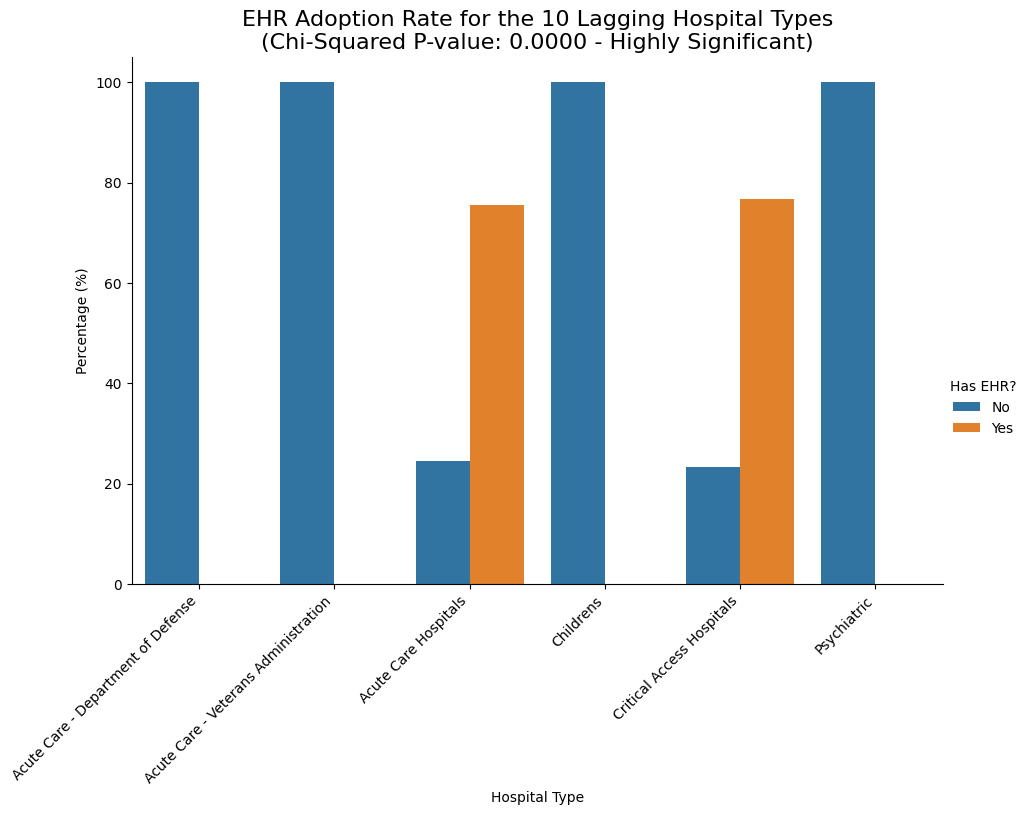

In [11]:
# 3d. Hospital Type vs. EHR Adoption Rate (Chi-Squared)

print("--- Hospital Type vs. EHR Adoption Rate (Chi-Squared) ---")

p_value_chi2 = 0.0000  # from previous Chi-Squared test result

# Focus on the 10 hospital types with the lowest adoption rates
lowest_adoption_types_df = crosstab_q3.sort_values(by='Adoption_Rate (%)', ascending=True).head(10)
relevant_types_list = lowest_adoption_types_df.index

# Filter the original dataframe for these hospital types
df_plot_q3 = df[df['Hospital Type'].isin(relevant_types_list)]

# Calculate percentages
plot_data = (df_plot_q3.groupby('Hospital Type')['Has_EHR']
             .value_counts(normalize=True)
             .mul(100)
             .rename('Percent')
             .reset_index())

g = sns.catplot(
    data=plot_data, 
    x='Hospital Type', 
    y='Percent', 
    hue='Has_EHR',    # Use 'Has_EHR' to create grouped bars ('Yes' vs 'No')
    kind='bar',
    height=6,        
    aspect=1.5        
)

g.ax.set_title(f'EHR Adoption Rate for the 10 Lagging Hospital Types\n(Chi-Squared P-value: {p_value_chi2:.4f} - Highly Significant)', fontsize=16)
g.set_axis_labels('Hospital Type', 'Percentage (%)')
g.legend.set_title('Has EHR?')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
plt.show()

***Analysis: Grouped Bar Chart for Question 3 (Chart 3d)***

* **Key Observation:** This chart provides a striking visualization of our highly significant Chi-Squared test. It plots the EHR adoption rates for the hospital types with the lowest adoption, starting from 0%.

* **Connection to Statistics:**
    * In comparison, the two most common hospital types, `Acute Care Hospitals` and `Critical Access Hospitals`, show a dominant 'Yes' bar, representing their **~76% adoption rate**.
    
* **Conclusion:** This visual powerfully explains *why* our Chi-Squared P-value was 0.0000. The association between `Hospital Type` and adoption is not subtle; it's an extreme, all-or-nothing divide for these specialty hospitals. This confirms that `Hospital Type` is a critical variable in our dataset, and that these specialty hospitals either do not participate in the EHR program or are not captured by our data.

### Comparative analysis 

In [12]:
df.isna().sum()

Facility ID                                                 0
Facility Name_x                                             0
Address_x                                                   0
City/Town_x                                                 0
State_x                                                     0
ZIP Code_x                                                  0
County/Parish_x                                             0
Telephone Number_x                                          0
Hospital Type                                               0
Hospital Ownership                                          0
Emergency Services                                          0
Meets criteria for birthing friendly designation         3153
Hospital overall rating                                     0
Hospital overall rating footnote                         2860
MORT Group Measure Count                                    0
Count of Facility MORT Measures                             0
Count of

In [13]:
column_lst = df.columns
column_lst

Index(['Facility ID', 'Facility Name_x', 'Address_x', 'City/Town_x', 'State_x',
       'ZIP Code_x', 'County/Parish_x', 'Telephone Number_x', 'Hospital Type',
       'Hospital Ownership', 'Emergency Services',
       'Meets criteria for birthing friendly designation',
       'Hospital overall rating', 'Hospital overall rating footnote',
       'MORT Group Measure Count', 'Count of Facility MORT Measures',
       'Count of MORT Measures Better', 'Count of MORT Measures No Different',
       'Count of MORT Measures Worse', 'MORT Group Footnote',
       'Safety Group Measure Count', 'Count of Facility Safety Measures',
       'Count of Safety Measures Better',
       'Count of Safety Measures No Different',
       'Count of Safety Measures Worse', 'Safety Group Footnote',
       'READM Group Measure Count', 'Count of Facility READM Measures',
       'Count of READM Measures Better',
       'Count of READM Measures No Different', 'Count of READM Measures Worse',
       'READM Group Footnot

In [14]:
df_copy = df.copy()

In [15]:
df_copy.dtypes

Facility ID                                               object
Facility Name_x                                           object
Address_x                                                 object
City/Town_x                                               object
State_x                                                   object
ZIP Code_x                                                 int64
County/Parish_x                                           object
Telephone Number_x                                        object
Hospital Type                                             object
Hospital Ownership                                        object
Emergency Services                                        object
Meets criteria for birthing friendly designation          object
Hospital overall rating                                   object
Hospital overall rating footnote                         float64
MORT Group Measure Count                                  object
Count of Facility MORT Me

In [16]:
# Replace specified strings with np.nan in the each column
replace_string = ['Not Available', 'N']
for _ in column_lst: 
    df_copy[_] = df_copy[_].\
        replace(replace_string, np.nan)


#  drop columns that match common patterns (handles _x / _y suffixes)
exclude_patterns = ['Address', 'ZIP Code', 'Telephone Number', \
                    'Start Date', 'End Date', '_y', 'Footnote']
cols_to_drop = [col for col in df_copy.columns if any(p in col for p in exclude_patterns)]

if cols_to_drop:
    df_copy = df_copy.drop(columns=cols_to_drop)
    print("Dropped columns:", cols_to_drop)

# remove trailing '_x' from column names in df_copy
cols_before = df_copy.columns.tolist()
cols_to_rename = [c for c in cols_before if c.endswith('_x')]

if cols_to_rename:
    rename_map = {c: c[:-2] for c in cols_to_rename}
    df_copy = df_copy.rename(columns=rename_map)
    print("Renamed columns:", rename_map)

# drop the columns with more than 50 % of missing value
threshold = len(df_copy) * 0.5
na_counts = df_copy.isna().sum()

# list columns with >= 50% missing
cols_over_threshold = na_counts[na_counts >= threshold].index.tolist()
if cols_over_threshold:
    print(f"Columns with >=50% missing (n = {len(cols_over_threshold)}):")
    print(na_counts[cols_over_threshold].sort_values(ascending=False))

# Columns to exclude
exclude_patterns = ['Facility ID', 'Facility Name', 'City/Town',
                    'County/Parish', 'Hospital Type', 'Hospital Ownership',
                    'Has_EHR', 'EHR_Vendor','CEHRT ID',\
                    'Meets criteria for promoting interoperability of EHRs',\
                    'Emergency Services',
                    'Meets criteria for birthing friendly designation','State']

# Select columns excluding the patterns
numeric_cols = df_copy.columns.difference(exclude_patterns)

# Convert selected columns to float
df_copy[numeric_cols] = df_copy[numeric_cols].astype(float)

# compute column-wise means for numeric columns and fill NaN with mean of columns
avg = df_copy.mean(numeric_only=True)
avg
df_copy = df_copy.fillna(avg)
print(df_copy.isna().sum() )



Dropped columns: ['Address_x', 'ZIP Code_x', 'Telephone Number_x', 'MORT Group Footnote', 'Safety Group Footnote', 'READM Group Footnote', 'Pt Exp Group Footnote', 'TE Group Footnote', 'Facility Name_y', 'Address_y', 'City/Town_y', 'State_y', 'ZIP Code_y', 'County/Parish_y', 'Telephone Number_y', 'Start Date', 'End Date']
Renamed columns: {'Facility Name_x': 'Facility Name', 'City/Town_x': 'City/Town', 'State_x': 'State', 'County/Parish_x': 'County/Parish'}
Columns with >=50% missing (n = 2):
Meets criteria for birthing friendly designation    3153
Hospital overall rating footnote                    2860
dtype: int64
Facility ID                                                 0
Facility Name                                               0
City/Town                                                   0
State                                                       0
County/Parish                                               0
Hospital Type                                               0
Hos

--- Comparative analysis: Hospital Ratings Grouped by 'Has_EHR' ---




/var/folders/3c/qb1wdl8j44l9m19z6w2ktjj00000gn/T/ipykernel_79286/1574950579.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_copy, x='Has_EHR', y='rating_numeric', ci='sd',


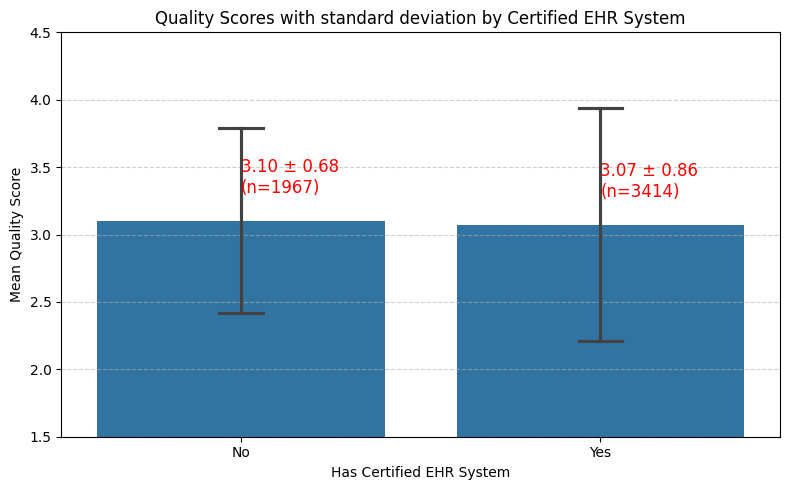

In [17]:
# Comparative analysis for Research Question 1
print("--- Comparative analysis: Hospital Ratings Grouped by 'Has_EHR' ---")
print('\n')

fig, ax = plt.subplots(figsize=(8,5))

# barplot with SD error bars
sns.barplot(data=df_copy, x='Has_EHR', y='rating_numeric', ci='sd', 
			capsize=0.12, ax=ax)
# compute group means and counts for annotations
group_means = df_copy.groupby('Has_EHR')['rating_numeric'].mean()
counts = df_copy.groupby('Has_EHR')['rating_numeric'].count()
stand_dev = df_copy.groupby('Has_EHR')['rating_numeric'].std()
# annotate bars with mean and sample size
for i, label in enumerate(group_means.index):
	m = group_means[label]
	n = counts[label]
	sd = stand_dev[label]
	ax.text(i, m + 0.18, f"{m:.2f} ± {sd:.2f}\n(n={n})", ha='left', 
		 va='bottom', fontsize=12, color='red')

ax.set_title('Quality Scores with standard deviation by Certified EHR System')
ax.set_xlabel('Has Certified EHR System')
ax.set_ylabel('Mean Quality Score')
ax.set_ylim(1.5, 4.5)

ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [18]:
model = ols('rating_numeric ~ Has_EHR', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rating_numeric   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.262
Date:                Sun, 02 Nov 2025   Prob (F-statistic):              0.133
Time:                        02:01:25   Log-Likelihood:                -4347.1
No. Observations:                2872   AIC:                             8698.
Df Residuals:                    2870   BIC:                             8710.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.1378      0.042     74.517      0.000       3.055       3.220
Has_EHR[T.Yes]    -0.0725      0.048     -1.504      0.133      -0.167       0.022
==============================================================================
Omnibus:                      153.382   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.501
Skew:                          -0.073   Prob(JB):                     4.42e-14
Kurtosis:                       2.298   Cond. No.                         3.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


***Analysis: Research Question 1 (Has_EHR vs. Rating)***

The bar chart above provides the information to our first research question: "Do hospitals with a certified EHR system report higher overall quality scores?"

* **Key Finding:** The compared analysis show : 

    The quality score of hospital between having EHR system and without EHR system have the closely score on quality score.

    * Without Certified EHR (n=1967): The mean hospital quality score is 3.10 ± 0.68

    * With Certified EHR (n=3414): The mean hospital quality score is 3.07 ± 0.86
* **Conclusion:** 

    The analysis shows that the difference between the means of the two groups is 0.03, but the ANOA analysis report reveals the mean difference between two group do not have static significant(Prob (F-statistic):0.133)  .  Additionally, the standard deviations (±0.68 and ±86) indicate substantial variation in quality scores within each group.





--- Comparative analysis: Hospital Ratings Grouped by 'EHR_Vendor' ---




/var/folders/3c/qb1wdl8j44l9m19z6w2ktjj00000gn/T/ipykernel_79286/4022187881.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_copy, x='EHR_Vendor', y='rating_numeric', ci='sd',


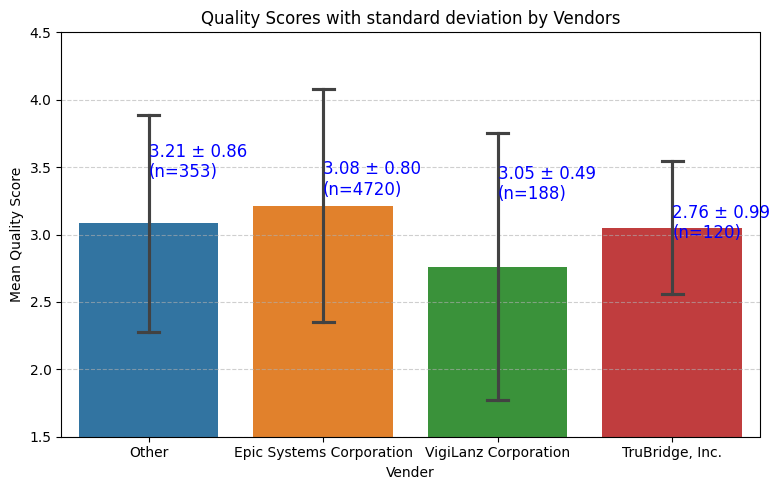



ANOVA analysis
                            OLS Regression Results                            
Dep. Variable:         rating_numeric   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.698
Date:                Sun, 02 Nov 2025   Prob (F-statistic):           2.22e-06
Time:                        02:01:25   Log-Likelihood:                -6443.1
No. Observations:                5381   AIC:                         1.289e+04
Df Residuals:                    5377   BIC:                         1.292e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [19]:
# Comparative analysis for Research Question 2
print("\n--- Comparative analysis: Hospital Ratings Grouped by 'EHR_Vendor' ---")
print('\n')
fig, ax = plt.subplots(figsize=(8,5))

# barplot with SD error bars
sns.barplot(data=df_copy, x='EHR_Vendor', y='rating_numeric', ci='sd', 
			capsize=0.12, ax=ax, hue="EHR_Vendor")
# compute group means and counts for annotations
group_means = df_copy.groupby('EHR_Vendor')['rating_numeric'].mean()
counts = df_copy.groupby('EHR_Vendor')['rating_numeric'].count()
stand_dev = df_copy.groupby('EHR_Vendor')['rating_numeric'].std()
# annotate bars with mean and sample size
for i, label in enumerate(group_means.index):
	m = group_means[label]
	n = counts[label]
	sd = stand_dev[label]
	ax.text(i, m + 0.18, f"{m:.2f} ± {sd:.2f}\n(n={n})", ha='left', 
		 va='bottom', fontsize=12, color='blue')

ax.set_title('Quality Scores with standard deviation by Vendors')
ax.set_xlabel('Vender')
ax.set_ylabel('Mean Quality Score')
ax.set_ylim(1.5, 4.5)

ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
print('\n')

print("ANOVA analysis")
model = ols('rating_numeric ~ EHR_Vendor', data=df_copy).fit()
print(model.summary())
print('\n')

print("Tukey\'s Honestly Significant Differences (HSD)")
res2 = pairwise_tukeyhsd(df_copy['rating_numeric'], df_copy['EHR_Vendor'])
print(res2.summary())

***Analysis: Research Question 2 (EHR_Vendor vs. Rating)***

The analysis above provides the information to explain our second research question: "Is there a difference in outcomes among hospitals using different EHR vendors?"

* **Key Finding:** The compared analysis show : 

    The quality score of hospital between venders have the closely score on quality score.

    * Other vendors (n = 353) ): The mean hospital quality score is 3.21 ± 0.86

    * Epic Systems Corporation (n=4720): The mean hospital quality score is 3.08 ± 0.80

    * VigiLanz Corporation (n=188)  :  The mean hospital quality score is  3.05 ± 0.49 

    * TruBridge, Inc.  (n=120) : The mean hospital quality score is 2.76 ± 0.99 

    * ANOVA analysis indicates that there has the relationship between venders and quality scores has statistically significant (F-statistic p-value: 2.22e-06).

    * Tukey HSD Results)explains : 

        1. Epic vs. Other Vendors:

            Epic’s mean quality score was 0.13 points lower than the average of other vendors (p = 0.0146), indicating a statistically significant difference.

        2. Epic vs. TruBridge:

            Epic’s mean score was 0.16 points higher than TruBridge (p = 0.1068), but this difference was not statistically significant.

        3. Epic vs. VigiLanz:

            Epic’s mean score was 0.45 points higher than VigiLanz (p < 0.001), representing a statistically significant difference.

        4. Other Vendors vs. VigiLanz:

            Other vendors scored 0.32 points higher than VigiLanz (p = 0.0001), also a statistically significant difference.
        
        5. Other Vendors vs. TruBridge:

            The difference between other vendors and TruBridge was small (0.03 points) and not statistically significant (p = 0.953).

        6. TruBridge vs. VigiLanz:

            TruBridge scored 0.29 points higher than VigiLanz (p = 0.011), a statistically significant difference.

* **Conclusion:** 

    The analysis indicates that hospital quality scores are generally similar across different EHR vendors, but statistically significant differences do exist, supported by an extremely small F-statistic P value. Tukey HSD suggests that some vendor relationships have distinct mean scores with significant differences, particularly between Epic and VigiLanz, and between other vendors and VigiLanz.




--- Comparative analysis for Q3: EHR Adoption Rate by Hospital Type ---




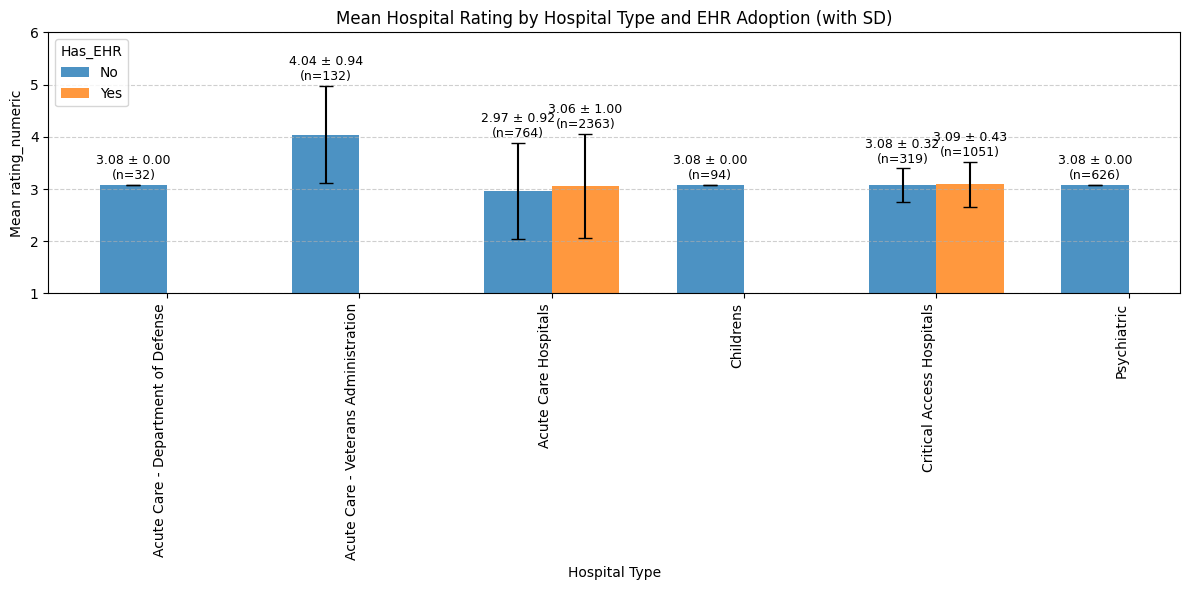

Acute Care EHR vs No EHR: t=2.38, p=0.0172
Critical Access EHR vs No EHR: t=0.75, p=0.4505


In [20]:
# Comparative analysis  for Research Question 3
print("\n--- Comparative analysis for Q3: EHR Adoption Rate by Hospital Type ---")
print('\n')
# Create a grouped bar chart of mean rating by Hospital Type with hue = Has_EHR
grouped_mean = df_copy.groupby(['Hospital Type', 'Has_EHR'])['rating_numeric'].mean().unstack(fill_value=np.nan)
grouped_std = df_copy.groupby(['Hospital Type', 'Has_EHR'])['rating_numeric'].std().unstack(fill_value=np.nan)
grouped_count = df_copy.groupby(['Hospital Type', 'Has_EHR'])['rating_numeric'].count().unstack(fill_value=0)

order = [c for c in ['No', 'Yes'] if c in grouped_mean.columns]

x = np.arange(len(grouped_mean.index))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))

for i, col in enumerate(order):
    offset = (i - (len(order)-1)/2) * width
    ys = grouped_mean[col].values
    yerr = grouped_std[col].values
    bars = ax.bar(x + offset, ys, width, label=col, yerr=yerr, capsize=5, alpha=0.8)
    # annotate mean ± sd and n
    counts = grouped_count[col].values
    for xi, yi, sdi, ni in zip(x + offset, ys, yerr, counts):
        if not np.isnan(yi):
            ax.text(xi, yi + (sdi if not np.isnan(sdi) else 0.05) + 0.05,
                    f"{yi:.2f} ± {0 if np.isnan(sdi) else sdi:.2f}\n(n={int(ni)})",
                    ha='center', va='bottom', fontsize=9, color='black')

ax.set_title('Mean Hospital Rating by Hospital Type and EHR Adoption (with SD)')
ax.set_xlabel('Hospital Type')
ax.set_ylabel('Mean rating_numeric')
ax.set_xticks(x)
ax.set_xticklabels(grouped_mean.index, rotation=90, ha='right')
ax.legend(title='Has_EHR')
ax.set_ylim(1, 6)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# select the type of hospital : 'Acute Care Hospitals', 'Critical Access Hospitals'
types_of_interest = ['Acute Care Hospitals', 'Critical Access Hospitals']
mask = df_copy['Hospital Type'].isin(types_of_interest)
df_subset = df_copy[mask]
df_subset = df_subset[["Hospital Type", "rating_numeric", "Has_EHR"]]
acute_mask = df_subset['Hospital Type'] == 'Acute Care Hospitals'
critical_mask = df_subset['Hospital Type'] == 'Critical Access Hospitals'

# t-test within each type
t_stat, p_val = stats.ttest_ind(
    df_subset[acute_mask & (df_subset['Has_EHR']=='Yes')]['rating_numeric'],
    df_subset[acute_mask & (df_subset['Has_EHR']=='No')]['rating_numeric'],
    equal_var=False
)
print("Acute Care EHR vs No EHR: t=%.2f, p=%.4f" % (t_stat, p_val))


t_stat2, p_val2 = stats.ttest_ind(
    df_subset[critical_mask & (df_subset['Has_EHR']=='Yes')]['rating_numeric'],
    df_subset[critical_mask & (df_subset['Has_EHR']=='No')]['rating_numeric'],
    equal_var=False
)
print("Critical Access EHR vs No EHR: t=%.2f, p=%.4f" % (t_stat2, p_val2))


***Analysis: Research Question 3 (Hospital Type, Adoption, & Outcomes)***

The analysis above provides the information to explain our second research question: "Are specific types of hospitals, such as smaller or rural "Critical Access Hospitals," lagging in EHR adoption, and does this correlate with their reported outcomes?"

* **Key Finding:** The compared analysis show : 

    The quality scores of hospitals across diverse hospital types and EHR adoption have a close correlation in terms of quality scores.

    * Only two type of hospital( Acute care Hospital and critical access hospital) have EHR adoption. 

    * In the group of hospitals WITHOUT EHR adoption:

        * Acute Care Hospitals (n = 764): The mean hospital quality score is 2.97 ± 0.92.
        * Veterans Administration Hospitals (n = 132): The mean hospital quality score is 4.04 ± 0.94.
        * Department of Defense Hospitals (n = 32): The mean hospital quality score is 3.08 ± 0.00.
        * Children’s Hospitals (n = 94): The mean hospital quality score is 3.08 ± 0.00.
        * Psychiatric Hospitals (n = 626): The mean hospital quality score is 3.08 ± 0.00.
        * Critical access hospital (n = 319) : The mean hospital quality score is 3.08 ± 0.32.

    * In the group of hospitals WITH EHR adoption:
        * Acute Care Hospitals (n = 2363): The mean hospital quality score is 3.06 ± 1.00.
        * Critical access hospital (n = 1051) : The mean hospital quality score is 3.09 ± 0.43.

    * Acute Care Hospitals: Quality scores were significantly higher among hospitals with EHR adoption compared to those without (t = 2.38, p = 0.0172). 
    
    * Critical Access Hospitals: There was no statistically significant difference in quality scores between hospitals with and without EHR adoption (t = 0.75, p = 0.4505).


* **Conclusion:** 

   * While overall quality scores were generally similar across hospital types, EHR adoption was associated with a modest but statistically significant improvement in quality among Acute Care Hospitals. In contrast, Critical Access Hospitals showed no meaningful difference in quality based on EHR adoption, suggesting that the impact of EHR implementation may vary by hospital type and operational context.

### Multivariate analysis

In [21]:
# Multivariate analysis for Research Question 1

# Selecting three feature and compute the group means 
print("--- Multivariate analysis : Hospital Ratings Grouped by 'Has_EHR' ---")
print('\n')

cols = [
    'Has_EHR',
    'Emergency Services',
    'Hospital Type'
]

pivot = pd.pivot_table(
    df_copy,
    values="rating_numeric",
    index=cols,
    aggfunc= ['mean']
).round(2)

# round for display clarity: sort by the mean rating_numeric column and show result
pivot.sort_values(by=[('mean', 'rating_numeric')], ascending=False)

--- Multivariate analysis : Hospital Ratings Grouped by 'Has_EHR' ---




mean
                                                                rating_numeric
Has_EHR Emergency Services Hospital Type                                      
No      Yes                Acute Care - Veterans Administration           4.17
        No                 Acute Care - Veterans Administration           3.32
Yes     No                 Acute Care Hospitals                           3.19
No      No                 Critical Access Hospitals                      3.17
Yes     Yes                Critical Access Hospitals                      3.09
No      No                 Acute Care - Department of Defense             3.08
                           Childrens                                      3.08
                           Psychiatric                                    3.08
        Yes                Acute Care - Department of Defense             3.08
                           Childrens                                      3.08
                           Psychiatric                                    3.08
Yes     No                 Critical Access Hospitals                      3.08
No      Yes                Critical Access Hospitals                      3.07
Yes     Yes                Acute Care Hospitals                           3.05
No      No                 Acute Care Hospitals                           3.02
        Yes                Acute Care Hospitals                           2.96

***Analysis: related to Research Question 1 (Has_EHR vs. Rating)***

* **Key Finding:**

    * The Acute Care and veterans ddministration  hospital with with emergency Services and no EHR support actually highest performance 4.17. 
    * The Acute Care hospital with emergency Services and no EHR support actually worsens performance (2.96). 

    * The quality performance range spans from 2.96 to 4.17 across combinations of EHR adoption, Emergency Services, and hospital type.


* **Conclusion:** 
    * The 1.21-point quality gap (41% difference) between VA hospitals with Emergency Services achieving 4.17 without EHRs and Acute Care hospitals with identical Emergency Services achieving only 2.96 without EHR.


In [22]:
# Multivariate analysis related to Research Question 2
# Selecting three feature and compute the group mean
print("\n--- Multivariate analysis: Hospital Ratings Grouped by 'EHR_Vendor' ---")
print('\n')

pivot = pd.pivot_table(
    df_copy,
    values=['rating_numeric'],
    index=['EHR_Vendor',"Hospital Type",'Has_EHR'],
    aggfunc= ['mean']
).round(2)
pivot.sort_values(by=[('mean', 'rating_numeric')], ascending=False)


--- Multivariate analysis: Hospital Ratings Grouped by 'EHR_Vendor' ---




mean
                                                                      rating_numeric
EHR_Vendor               Hospital Type                        Has_EHR               
Other                    Acute Care - Veterans Administration No                4.04
Epic Systems Corporation Acute Care Hospitals                 Yes               3.24
                         Critical Access Hospitals            Yes               3.15
Other                    Critical Access Hospitals            Yes               3.09
                         Acute Care - Department of Defense   No                3.08
                         Childrens                            No                3.08
                         Critical Access Hospitals            No                3.08
                         Psychiatric                          No                3.08
                         Acute Care Hospitals                 Yes               3.06
TruBridge, Inc.          Critical Access Hospitals            Yes               3.06
                         Acute Care Hospitals                 Yes               3.02
Other                    Acute Care Hospitals                 No                2.97
VigiLanz Corporation     Acute Care Hospitals                 Yes               2.76

***Analysis: Research Question 2 (EHR_Vendor vs. Rating)***
* **Key Finding:**
    * The other vendor with a veteran acute hospital and EHR support actually has the highest average of quality performance (4.04). 

    * The VigiLanz Corporation, which has an acute care hospital and EHR support, actually lowers the average of quality performance (2.76). 

    * The range of quality performance spans from 2.76 to 4.04 across different combinations of EHR vendor, hospital type, and EHR support.

* **Conclusion:** 

    * The 46% quality performance gap range from 2.76 to 4.04 demonstrates that EHR vendor, hospital type, and EHR support are the primary determinants of healthcare quality.

In [23]:
# Multivariate analysis related to  Research Question 3
# Selecting three feature and compute the group mean
print("\n--- Multivariate analysis for Q3: EHR Adoption Rate by Hospital Type ---")
print('\n')

pivot = pd.pivot_table(
    df_copy,
    values=['rating_numeric'],
    index=['Hospital Type','Has_EHR',"Hospital Ownership"],
    aggfunc= ['mean']
).round(2)
pivot.sort_values(by=[('mean', 'rating_numeric')], ascending=False)


--- Multivariate analysis for Q3: EHR Adoption Rate by Hospital Type ---




mean
                                                                                         rating_numeric
Hospital Type                        Has_EHR Hospital Ownership                                        
Acute Care - Veterans Administration No      Veterans Health Administration                        4.04
Critical Access Hospitals            No      Voluntary non-profit - Church                         3.25
Acute Care Hospitals                 Yes     Government - Federal                                  3.24
                                     No      Voluntary non-profit - Other                          3.22
                                     Yes     Voluntary non-profit - Church                         3.22
                                     No      Voluntary non-profit - Church                         3.21
                                     Yes     Voluntary non-profit - Private                        3.18
                                     No      Physician                                             3.17
                                     Yes     Voluntary non-profit - Other                          3.17
                                             Physician                                             3.14
Critical Access Hospitals            No      Proprietary                                           3.13
                                     Yes     Voluntary non-profit - Private                        3.12
Acute Care Hospitals                 No      Voluntary non-profit - Private                        3.10
Critical Access Hospitals            No      Government - Local                                    3.09
                                     Yes     Proprietary                                           3.09
                                             Government - Federal                                  3.08
                                             Government - State                                    3.08
                                     No      Tribal                                                3.08
                                             Government - State                                    3.08
Acute Care - Department of Defense   No      Department of Defense                                 3.08
Critical Access Hospitals            Yes     Tribal                                                3.08
Psychiatric                          No      Government - Hospital District or Authority           3.08
                                             Government - Local                                    3.08
                                             Government - State                                    3.08
                                             Physician                                             3.08
                                             Proprietary                                           3.08
                                             Voluntary non-profit - Church                         3.08
                                             Voluntary non-profit - Other                          3.08
                                             Government - Federal                                  3.08
Critical Access Hospitals            No      Government - Federal                                  3.08
Psychiatric                          No      Voluntary non-profit - Private                        3.08
Childrens                            No      Voluntary non-profit - Other                          3.08
                                             Voluntary non-profit - Church                         3.08
                                             Proprietary                                           3.08
Acute Care Hospitals                 No      Tribal                                                3.08
Childrens                            No      Government - State                                    3.08
                                           

***Analysis: Research Question 3 (Hospital Type, Adoption, & Outcomes)***

* **Key Finding:** 
    * The Acute Care hospital with Veterans Administration and Veterans Health Administration support, and no EHR support, actually achieves the highest performance (4.04).  

    * The Acute Care hospital with no EHR support and government ownership actually performs worse (2.51).  

    * The quality performance range spans from 2.51 to 4.04 across different combinations of Hospital Type, EHR support, and Hospital Ownership.
* **Conclusion:** 

    * The 61% quality gap from 2.51 to 4.04 support that integrated care delivery models and organizational governance structures—not technology adoption or ownership type determine healthcare quality outcomes.



### Synthesis

The analysis report evaluates the quality score based on EHR adoption, EHR vendor selection, and hospital types. Through descriptive statistics, inferential statistics, graphical analysis, comparative analysis, and multivariate analysis, the analysis results offer a comprehensive understanding of the performance across hospitals in the USA.

***Research Question 1 mentions that if the hospital with EHR adoption could get a higher quality score on performance than the hospital which do not have EHR adoption.***

Based on the results of descriptive and inferential statistics, comparative analysis reveals that there is no statistically significant difference between EHR adoption and the quality score. The descriptive statistics show that there is no significant difference in the average quality ratings between hospitals that have reported an EHR system and those that do not, while the inferential statistic uses a P-value (0.1484) to fail to reject the null hypothesis, indicating no statistical difference between the two groups’ average scores on the quality rating. In graphical analysis, the histogram of quality ratings may not exhibit heavy skewness. Based on the ANOVA report in the comparative analysis, the mean difference between the two groups is supported by an F-statistic P-value of 0.133. The outcome from multivariate analysis reveals a 41% difference in quality between VA hospitals with Emergency Services and no EHR adoption and acute care hospitals with emergency Services and no EHR support. Overall, the results indicate that merely implementing an EHR system does not lead to better quality outcomes.

***Research Question 2 examines whether hospitals utilizing different EHR vendors display varying levels of performance.***

The result of the analysis for research question two is familiar. The descriptive statistics show that EHR vendor selection has clear differences in average ratings, and the inferential statistic reveals a significant difference in the mean quality ratings among different EHR vendor groups, supported by an F-statistic P-value of 0.0003. At the same time, graphical analysis shows the same result as the inferential statistic. Additionally, ANOA analysis shows that hospital quality scores are mostly similar across different EHR vendors. However, there are small but statistically significant differences, supported by a very small F-statistic P-value. In the results of Turkey HSD, two relationships—between Epic and VigiLanz, and between other vendors and VigiLanz—have significant differences in their mean quality scores, but other relationships between remaining vendors do not show significant differences. Multivariate analysis indicates a 46% quality performance gap, demonstrating that EHR vendor, hospital type, and EHR support significantly influence outcomes. Overall, the analysis reveals that the selection of EHR vendors, along with hospital categorization and EHR support levels, plays crucial roles in influencing quality outcomes. Notably, certain vendors such as VigiLanz demonstrate significantly lower performance metrics compared to their counterparts.

***Research Question 3 explores whether hospital types lag in EHR adoption and if differences in adoption relate to differences in outcomes***

Contrary to our initial assumption, critical access hospitals demonstrated a slightly higher EHR adoption rate (76.7%) compared to acute care hospitals (75.6%). Other hospital types in the dataset, including specialty hospitals such as psychiatric, children's, and VA facilities, did not adopt EHRs at all (0%). Graphical analysis of the two most common hospital types, acute care and critical access hospitals, confirms adoption rates near 76%, while other types show no adoption. Moreover, the comparative analysis indicates that quality scores were generally similar across hospital types. EHR adoption was associated with a modest but statistically significant improvement in quality among acute care hospitals. In contrast, critical access hospitals showed no meaningful difference in quality based on EHR adoption. Furthermore, multivariate analysis supports that the observed 61% quality gap suggests that integrated care delivery models and organizational governance structures, rather than technology adoption or hospital ownership type, are the primary determinants of healthcare quality outcomes. Overall, while EHR adoption is widespread among acute and critical care hospitals, its effect on quality appears limited and context-dependent, and it highlights that organizational factors play a more critical role in driving healthcare performance.

### Reflection

***Reflection on the Data Analysis Process***
* Identified and replaced specific strings ('Not Available', 'N') by using np.nan. This step ensures that there is no inappropriate data that could impact the outcome of the analysis. 
* Dropping the redundant and irrelevant columns to improve clarity and reduce the noise for the following analysis. Additionally, this step helps in focusing on the most important data to make the process of analysis more efficient.
* Remove the suffix, such as “_x”, from column names to standardize the column naming convention. This could enhance the clarity and readability of dataset, reducing possible confusion during interpretation. 
* Managing the columns from the original data and calculating the percentage of missing values, identifying columns with more than 50% missing data, and deciding whether to exclude or impute these columns in downstream analysis. It also leads to one of the challenges that will be discussed in the following content. This step maintains the high quality of data whenever possible. 
* Utilizing pivot tables or crosstab tables to aggregate and average data across selected categories. This process offers structured thought and makes it easy to explore the comparison between two groups. 

***Challenges and Solutions***

This dataset has some missing values in columns, especially in the rating_numeric columns. It may raise concerns for stakeholders when they apply the analysis results because this analysis from this dataset cannot provide a comprehensive and persuasive analysis. This challenge could limit and restrict the extent to which the findings from analysis across the various healthcare institutions can be reliably used or generalized. Addressing these missing values through proper data cleaning and imputation methods is essential to improve the overall quality and reliability of the insights derived. Without this, decision-making based on the analysis may be biased or incomplete, potentially leading to misguided strategies in healthcare planning and policy formulation. 

***Suggestion and Improvement***

This analysis uses hospital data from a specific region or type in the USA. It may not fully represent the diversity of the national medical landscape. Therefore, future research should include data from various locations, hospital sizes, and types. For example, participants could include urban and rural hospitals, as well as teaching and non-teaching hospitals. This approach could lead to more comprehensive and generalizable findings and reduce the risk of sample selection bias. Meanwhile, the results could offer more detailed insights or trends by comparing the adoption rates and quality indicators of HER across different healthcare settings. In conclusion, expanding the scope of research will enhance the understanding of healthcare technology adoption and improve the applicability of the findings across diverse healthcare environments.
